In [2]:

import rtree, pygeos
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import folium

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta

C:\Anaconda3\envs\geo37\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:

data_path = 'C:/Users/mhudgell/data/ais/'
telemetry_df = pd.read_parquet(data_path, engine='pyarrow')

In [5]:
telemetry_df =  telemetry_df[['mmsi', 'acquisition_time', 'longitude', 'latitude', 'sog', 'cog']]

In [6]:
local_df = telemetry_df[((telemetry_df['latitude'] > 51.85975370) &  (telemetry_df['latitude'] < 55.34311203)) &
                        ((telemetry_df['longitude'] > -7.33234434) & (telemetry_df['longitude'] < -2.45881019))]                


In [7]:
print(len(local_df.index), len(telemetry_df.index))

35436 12534115


In [8]:
geometry = [Point(xy) for xy in zip(local_df.longitude, local_df.latitude)]
crs = {'init': 'epsg:4326'} #4326
telemetry_gdf = gpd.GeoDataFrame(local_df, crs=crs, geometry=geometry)



C:\Anaconda3\envs\geo37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


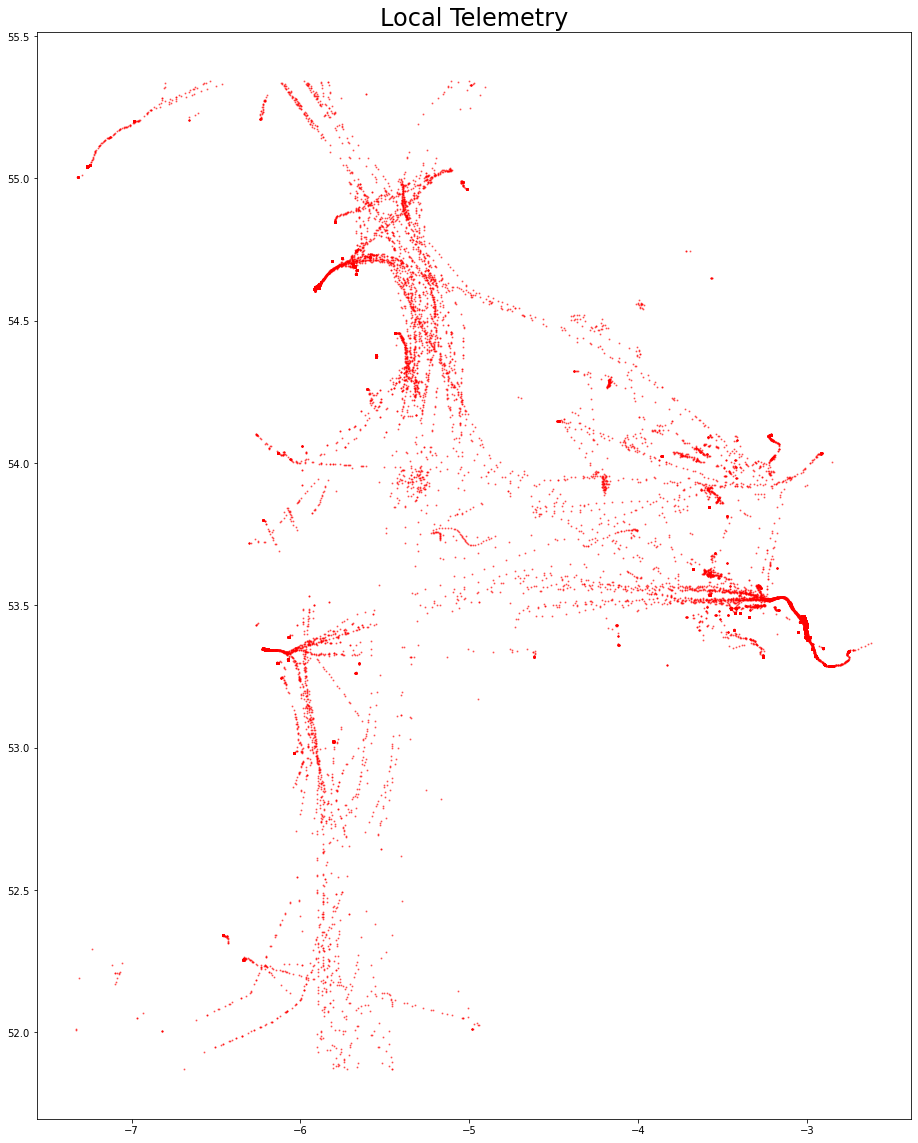

In [9]:

fig, ax = plt.subplots(figsize=(20, 20))
telemetry_gdf.plot(ax=ax, alpha=.5, markersize=1, color='red')
ax.set_title('Local Telemetry', fontsize=24, loc='center')
plt.savefig("C:/Users/mhudgell/figures/local.png")
plt.show()

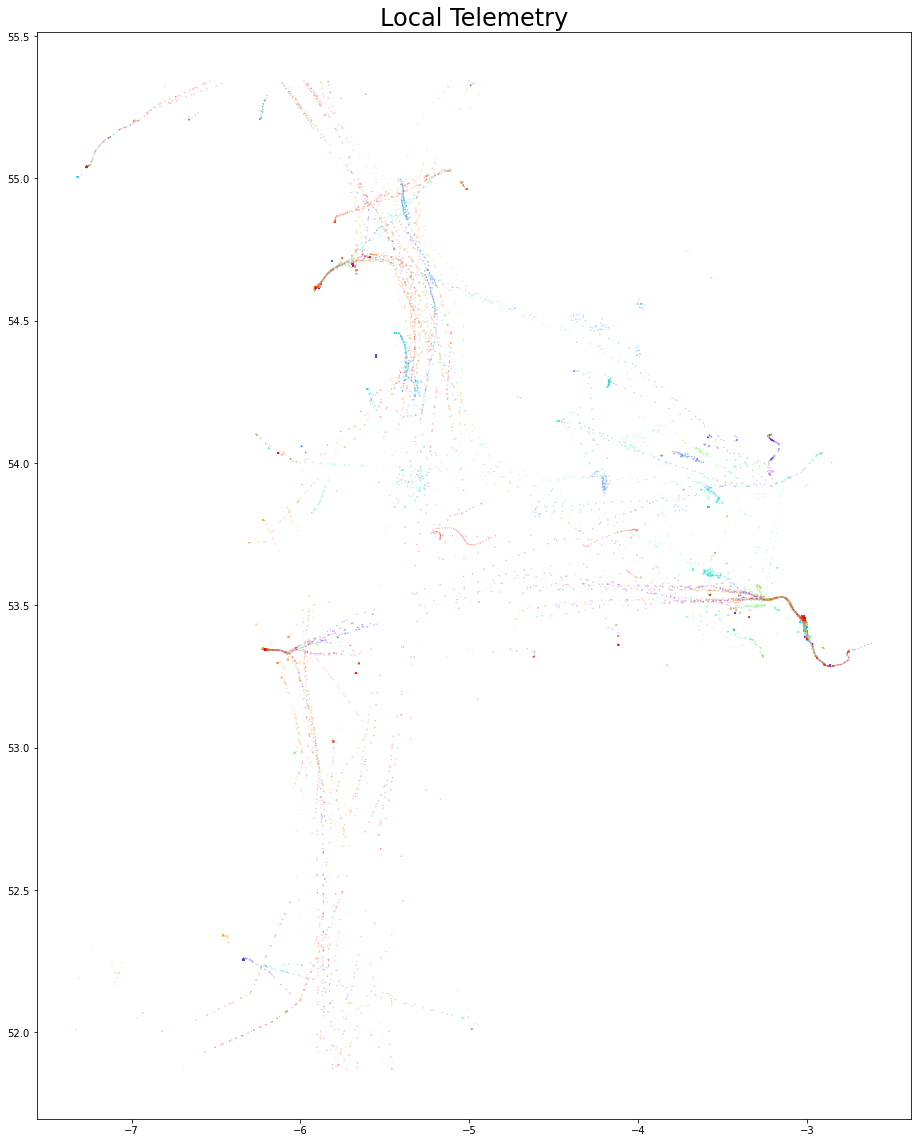

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
telemetry_gdf.plot(ax=ax, alpha=.5, column='mmsi', cmap='rainbow', legend=False, markersize=0.1)
ax.set_title('Local Telemetry', fontsize=24, loc='center')
plt.savefig("C:/Users/mhudgell/figures/local.png")
plt.show()


#gdf.plot(figsize=(20,10), column='cog', cmap='hot', legend=True, markersize=0.01)

In [11]:
good_df = pd.DataFrame(telemetry_gdf.groupby(['mmsi'],as_index=False).agg(count=('mmsi','count')))
good_df = good_df[(good_df['count'] > 1)]

In [12]:
telemetry_gdf = telemetry_gdf.merge(good_df, on='mmsi')

In [13]:
len(telemetry_gdf.index)

35414

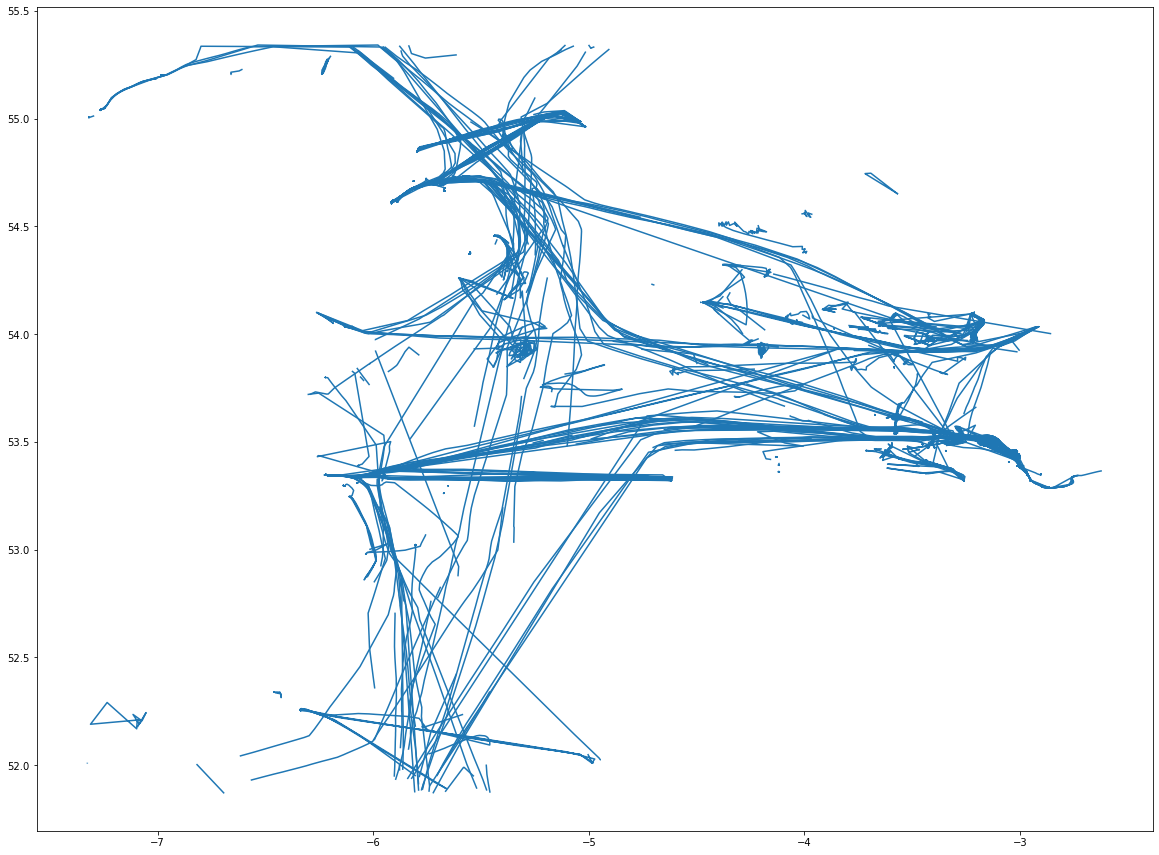

In [50]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_df2.plot(ax=ax)
plt.show()

In [51]:

sorted_df = telemetry_gdf.sort_values(by=['mmsi', 'acquisition_time'], ascending=True)


In [57]:
from shapely.geometry import Point, LineString, shape

sorted_df['x'] = sorted_df.geometry.x
sorted_df['y'] = sorted_df.geometry.y
sorted_df['coordinates'] = sorted_df.apply(lambda row: (row['y'], row['x']), axis=1)

geo_df1 = sorted_df.groupby(['mmsi'])['geometry'].apply(lambda x: LineString(x.tolist()))
                                   
geo_df2 = gpd.GeoDataFrame(geo_df1, geometry='geometry')
geo_dfx = pd.DataFrame(sorted_df.groupby(['mmsi'])['coordinates'].apply(lambda x: x.tolist()))
                       
          

In [58]:
geo_dfx

,coordinates
mmsi,
205071000,"[(53.430725, -3.00028), (53.430702, -3.000277)..."
209066000,"[(53.321942, -2.95197), (53.321933, -2.951978)..."
209093000,"[(52.20066, -6.167317), (52.211067, -6.185873)..."
209146000,"[(53.332317, -4.612105), (53.35407, -5.40047),..."
209192000,"[(54.61831, -5.89533), (54.618237, -5.895317),..."
...,...
636017002,"[(53.454815, -3.014357), (53.454832, -3.0143),..."
636018261,"[(54.164992, -5.364913), (54.235, -5.351667), ..."
636018663,"[(53.455952, -3.014327), (53.455952, -3.014327..."


In [59]:
import folium

In [60]:
# Setup a folium map at a high-level zoom
map = folium.Map(location=(54,-5), zoom_start=1)

for idx, row in geo_dfx.iterrows():
    folium.PolyLine(locations=row['coordinates']).add_to(map)
map
